In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE=(224,224)

In [3]:
import pathlib
data_dir=pathlib.Path("/home/sanjana/Desktop/med_img/cervical-cancer2")
data_dir

PosixPath('/home/sanjana/Desktop/med_img/cervical-cancer2')

In [4]:
image_count=len(list(data_dir.glob('*/*jpg')))
image_count

1702

In [5]:
lesions_dict={
    'NILM': list(data_dir.glob('NILM/*')),
    'LSIL': list(data_dir.glob('LSIL_new/*')),
    'HSIL': list(data_dir.glob('HSIL_new/*')),
    'SCC': list(data_dir.glob('SCC_new/*')),
}

In [6]:
len(lesions_dict['NILM'])

612

In [7]:
lesions_labels={
    'NILM': 0,
    'LSIL': 1,
    'HSIL': 2,
    'SCC': 3,
}

In [8]:
x, y=[],[]
for lesions_name, images in lesions_dict.items():
    for image in images:
        img=cv2.imread(str(image))
        x.append(img)
        y.append(lesions_labels[lesions_name])

In [9]:
x=np.array(x)
y=np.array(y)

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [11]:
x_train_scaled=x_train/255
x_test_scaled=x_test/255
x_val_scaled=x_val/255
print(len(x_train_scaled))
print(len(x_val_scaled))
print(len(x_test_scaled))

810
271
271


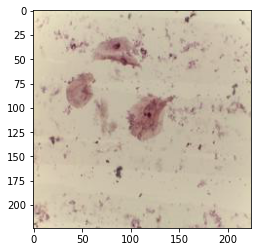

In [13]:
plt.imshow(x[200])

In [14]:
classifier="https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"
mod=hub.KerasLayer(classifier, input_shape=(224,224,3), trainable=False)

In [15]:
num_lesions=4

model=tf.keras.Sequential([
    mod, 
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(num_lesions)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              3413024   
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 5,251,620
Trainable params: 1,838,596
Non-trainable params: 3,413,024
_________________________________________________________________


In [16]:
from tensorflow.python.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [17]:
import matplotlib.pyplot as plt

model.compile(
    optimizer="adam", 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])
history = model.fit(x_train_scaled, y_train, validation_data=(x_val_scaled, y_val), batch_size=20,epochs=30,callbacks = es)


Epoch 1/30
41/41 [==============================] - 68s 2s/step - loss: 0.2887 - acc: 0.8840 - val_loss: 0.1136 - val_acc: 0.9557
Epoch 2/30
41/41 [==============================] - 26s 618ms/step - loss: 0.0583 - acc: 0.9827 - val_loss: 0.1170 - val_acc: 0.9631
Epoch 3/30
41/41 [==============================] - 17s 422ms/step - loss: 0.0367 - acc: 0.9877 - val_loss: 0.0512 - val_acc: 0.9742
Epoch 4/30
41/41 [==============================] - 16s 395ms/step - loss: 0.0261 - acc: 0.9889 - val_loss: 0.0878 - val_acc: 0.9631
Epoch 5/30
41/41 [==============================] - 16s 397ms/step - loss: 0.0123 - acc: 0.9951 - val_loss: 0.0436 - val_acc: 0.9779
Epoch 6/30
41/41 [==============================] - 16s 400ms/step - loss: 0.0089 - acc: 0.9975 - val_loss: 0.1288 - val_acc: 0.9594
Epoch 7/30
41/41 [==============================] - 16s 401ms/step - loss: 0.0203 - acc: 0.9901 - val_loss: 0.0811 - val_acc: 0.9668
Epoch 8/30
41/41 [==============================] - 17s 408ms/step - los

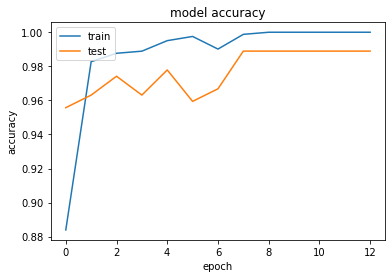

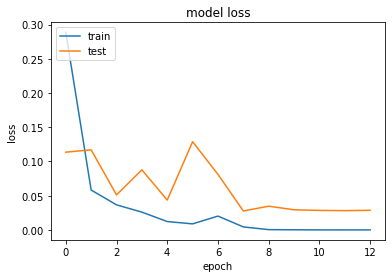

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
model.evaluate(x_test_scaled, y_test)

9/9 [==============================] - 4s 440ms/step - loss: 0.0733 - acc: 0.9742


[0.07328899949789047, 0.9741697311401367]

In [21]:
preds=model.predict(x_test_scaled)
pred_classes=np.argmax(preds, axis=1)
pred_classes

array([1, 1, 0, 0, 2, 3, 3, 0, 3, 0, 2, 2, 0, 2, 3, 0, 2, 1, 2, 2, 1, 2,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 2, 0, 0,
       0, 1, 1, 1, 0, 0, 3, 1, 3, 3, 3, 0, 0, 0, 1, 2, 1, 1, 2, 1, 0, 0,
       3, 3, 3, 3, 2, 3, 3, 1, 0, 3, 2, 0, 0, 0, 1, 1, 0, 3, 3, 3, 0, 3,
       1, 2, 3, 0, 3, 0, 0, 3, 0, 3, 3, 2, 0, 2, 3, 2, 0, 1, 1, 0, 2, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 2, 1, 0, 0, 1,
       1, 3, 0, 3, 3, 0, 1, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 3, 2, 0,
       3, 2, 0, 3, 3, 3, 0, 0, 2, 0, 2, 0, 0, 3, 2, 2, 2, 0, 1, 0, 3, 0,
       3, 1, 0, 0, 0, 0, 1, 0, 0, 0, 3, 2, 2, 0, 1, 3, 0, 0, 0, 0, 2, 3,
       1, 0, 0, 0, 1, 0, 2, 0, 3, 1, 2, 3, 3, 0, 0, 0, 1, 0, 0, 2, 3, 0,
       1, 1, 3, 2, 0, 0, 1, 3, 0, 0, 3, 2, 0, 1, 1, 3, 0, 0, 1, 0, 2, 0,
       0, 2, 1, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 2, 0, 0, 1, 1, 0, 0, 1,
       3, 0, 0, 0, 0, 2, 0])

In [22]:
class_labels=[0,1,2,3]
import sklearn.metrics as metrics
report = metrics.classification_report(y_test, pred_classes, class_labels)
print(report) 
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_classes)

/home/sanjana/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2, 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       127
           1       0.94      1.00      0.97        47
           2       0.90      0.92      0.91        39
           3       1.00      0.97      0.98        58

    accuracy                           0.97       271
   macro avg       0.96      0.97      0.96       271
weighted avg       0.98      0.97      0.97       271



array([[125,   0,   2,   0],
       [  0,  47,   0,   0],
       [  0,   3,  36,   0],
       [  0,   0,   2,  56]])